In [1]:
import numpy as np
import os
import shutil
from pImpactR import MLI as mli
from pImpactR import opt
from pImpactR.util import Me
from copy import deepcopy as copy
import time
import pickle

In [2]:
Rsphere = 0.3
Espread = 2.0e-3
npt = 4096
nturn = 5

# Read MLI input file

In [3]:
elems0,lattices,labor = mli.readInputfile('mli.in.t3_iota_8_4_t0p4')
del(lattices[-1])

setarclen is not recognized. skipping...
autoconcat is not recognized. skipping...
autoapply is not recognized. skipping...
reftraj is not recognized. skipping...
fit is not recognized. skipping...
bip is not recognized. skipping...
tip is not recognized. skipping...


In [4]:
energy=elems0[0].energy*1.0e9
gam0 = energy/Me
bet0 = np.sqrt(1.0-1.0/gam0**2)

In [5]:
elems = []
for item in elems0:
    if not item.name in ['tasm','aim','vary','clear','anaprint']:
        elems.append(item)
elems[2].driftexact = 1

In [6]:
labor = ['iotaline','mapout','fin']

# thick sext 2 thin multipole

In [7]:
elemList,latticeList=mli.sext2thin(elems,lattices,brho=0.50204778184582999)

In [8]:
mli.writeInputfile(elemList,latticeList,labor)

In [9]:
mli.run()

In [10]:
M,G=mli.readTransferMap()

In [11]:
M

,1,2,3,4,5,6
1,0.999968,0.000070,0.000000,0.000000e+00,0.0,-1.147949e-06
2,-1.454445,0.999930,0.000000,0.000000e+00,0.0,-2.587771e-07
3,0.000000,0.000000,0.999995,3.984744e-07,0.0,0.000000e+00
4,0.000000,0.000000,-1.454438,1.000004e+00,0.0,0.000000e+00
5,0.000002,-0.000001,0.000000,0.000000e+00,1.0,-1.297155e+00
6,0.000000,0.000000,0.000000,0.000000e+00,0.0,1.000000e+00


In [12]:
G.head()

,exponents,GP
28,f( 30 00 00 ),-23.555531
29,f( 21 00 00 ),-62.881728
33,f( 20 00 01 ),21.191487
34,f( 12 00 00 ),-51.643332
38,f( 11 00 01 ),54.729188


In [13]:
indexThin = []
k2lList = []
for i,item in enumerate(elemList):
    if 'thlm' == item.elem:
        indexThin.append(i)
        k2lList.append(item.k2l)
nThin = len(indexThin)
print(nThin)

18


# Optimize

### prepare input file

In [14]:
NL_nu = 0.3
NL_L  = 1.8
NL_c  = 0.01
NL_t  = 0.4
alfx = np.tan(np.pi*NL_nu)
betx = NL_L/np.sin(2.0*np.pi*NL_nu)
k = 2*alfx/betx
print(k)

1.4544633270832747


In [15]:
G2_ref = G.loc[28:76].copy()
G2_ref['GP'] = 0
G2_ref.loc[33,'GP'] = 0.5*k/bet0
G2_ref.loc[67,'GP'] = 0.5*k/bet0
G2_ref.head()

,exponents,GP
28,f( 30 00 00 ),0.000000
29,f( 21 00 00 ),0.000000
33,f( 20 00 01 ),0.727236
34,f( 12 00 00 ),0.000000
38,f( 11 00 01 ),0.000000


In [16]:
G3_ref = G.loc[84:200].copy()
G3_ref['GP'] = 0
G3_ref.loc[104,'GP'] = k/(2.0*bet0*gam0)**2
G3_ref.loc[184,'GP'] = k/(2.0*bet0*gam0)**2

In [17]:
elemListTrack = elemList[:3]
raysin  =mli.getElem.raytrace(file1='rays.in',type='readonly')
dump    =mli.getElem.particledump(file='rays.out',precision=15)
track   =mli.getElem.autotrack(type='symplectic',order=5)
fin     =mli.getElem.fin
nlinsert = mli.getElem.nlinsert(steps=100)
readmap = mli.getElem.tmi(name='readmap')
savemap = mli.getElem.stm(name='savemap')
getmap    = mli.getElem.gtm(name='getmap')
elemListTrack = elemListTrack + [raysin,dump,track,fin,nlinsert,readmap,savemap,getmap]
trackLine = [mli.getElem.line(name='trackLine',elemList = ['nlinsert','getmap',dump.name])]
trackLabor = mli.buildLabor(['readmap','savemap','clear',raysin.name,track.name,str(nturn)+'*'+trackLine[0].name,'fin'])
mli.writeInputfile(elemListTrack,trackLine,trackLabor)

### prepare particles

In [18]:
def MLI2norm(data_in,sign=1):
    data=data_in.copy()
    data[:,5] = np.sqrt(1.0-2.0*data[:,5]/bet0+data[:,5]**2)-1.0
    data[:,1] = (data[:,0]*alfx*sign/np.sqrt(betx) + data[:,1]/(1+data[:,5])*np.sqrt(betx))/NL_c
    data[:,3] = (data[:,2]*alfx*sign/np.sqrt(betx) + data[:,3]/(1+data[:,5])*np.sqrt(betx))/NL_c
    data[:,0] = data[:,0]/(np.sqrt(betx)*NL_c)
    data[:,2] = data[:,2]/(np.sqrt(betx)*NL_c)
    return data
    
def norm2MLI(data_in,sign=1):
    data=data_in.copy()
    data[:,1] = (-data[:,0]*alfx*sign + data[:,1])*NL_c/np.sqrt(betx)*(1+data[:,5])
    data[:,3] = (-data[:,2]*alfx*sign + data[:,3])*NL_c/np.sqrt(betx)*(1+data[:,5])
    data[:,0] = data[:,0]*np.sqrt(betx)*NL_c
    data[:,2] = data[:,2]*np.sqrt(betx)*NL_c
    data[:,5] = -np.sqrt((1.0+data[:,5])**2+1.0/(bet0*gam0)**2)+1.0/bet0
    return data

In [19]:
def getTBT(npt,nturn,fname='rays.out'):
    TBT = np.loadtxt(fname)
    TBT = TBT[:npt*nturn,:6]
    out = np.zeros([npt,nturn,6])
    for i in range(nturn):
        out[:,i,:] = TBT[i*npt:(i+1)*npt,:]
        out[:,i,:] = MLI2norm(out[:,i,:])
    return out,TBT[npt*(nturn-1):,:]

In [20]:
def getInv(xn,pxn,yn,pyn,delta,tau=NL_t):
    z = xn + 1j*yn
    U = np.real(z/np.sqrt(1-z**2)*np.arcsin(z))
    W = np.real(2*xn/np.sqrt(1-z**2)*np.arcsin(z))
    Hn = 0.5*(xn**2+pxn**2+yn**2+pyn**2)   +tau*U/(1.0+delta)
    In = (xn*pyn -yn*pxn)**2 +xn**2+pxn**2 +tau*W/(1.0+delta)
    return Hn,In

def getInvTBT(TBT):
    npt,nturn,dummy = TBT.shape
    InvTBT = np.zeros([npt,nturn,2])
    for iturn in range(nturn):
        data = TBT[:,iturn,:]
        for ipt in range(npt):
            xn    = data[ipt,0]
            pxn   = data[ipt,1]
            yn    = data[ipt,2]
            pyn   = data[ipt,3]
            delta = data[ipt,5]
            InvTBT[ipt,iturn,:] = getInv(xn,pxn,yn,pyn,delta)
    return InvTBT

In [21]:
def getINVobj(INV,INV0):
    obj=0.0
    for i in range(nturn):
        tmp = np.sum((INV[:,i,0]/INV0[:,0,0]-1.0)**2) + np.sum((INV[:,i,1]/INV0[:,0,1]-1.0)**2)
        if tmp > 1.0e6:
            return 1.0e6
        obj = obj + tmp
    return np.sqrt(obj)/(npt*2)

# check Obj

In [22]:
#%%
pData=np.zeros([npt,6])

def objFunc(arg): 
    target = opt.id_generator()  # generage random directory name
    while os.path.exists(target):  
        target = opt.id_generator()
    shutil.copytree('origin', target)
    os.chdir(target) # cd to the randome directory and
    
    for i,j in enumerate(indexThin):
        elemList[j]['k2l']=arg[i]
    for i,j in enumerate(indexThin):
        elemList[j]['k3l']=arg[i+nThin]
        
    mli.writeInputfile(elemList,latticeList,labor)
    mli.run()
    M,G = mli.readTransferMap()
    
    obj1 = np.sum((G.loc[28 :76 ,'GP'].values-G2_ref['GP'].values)**2) \
         +1.0e-10* np.sum((G.loc[84 :200,'GP'].values-G3_ref['GP'].values)**2)
    if obj1 > 200:
        os.chdir('..')
        shutil.rmtree(target)
        return obj1
    else:
        
        readmap.map2file(M,G)
        # prepare particles
        x = np.random.random([npt,4])
        c0 = np.cos(x[:,0])
        s0 = np.sin(x[:,0])
        c1 = np.cos(x[:,1])
        s1 = np.sin(x[:,1])
        c2 = np.cos(x[:,2])
        s2 = np.sin(x[:,2])
        pData[:,0] = Rsphere*c0
        pData[:,1] = Rsphere*s0*c1
        pData[:,2] = Rsphere*s0*s1*c2
        pData[:,3] = Rsphere*s0*s1*s2
        pData[:,5] = (x[:,3]-0.5)*Espread
        pDataIn = norm2MLI(pData,sign=1)
        np.savetxt('rays.in',pDataIn)
        
        mli.writeInputfile(elemListTrack,trackLine,trackLabor)
        mli.run(32)
        TBT,pDataOut = getTBT(npt,nturn)
        Inv0 = getInvTBT(pData.reshape(npt,1,6))
        Inv = getInvTBT(TBT)
        obj2 = getINVobj(Inv,Inv0)*20
        
        obj2tot = obj2
        for i in range(200):
            np.savetxt('rays.in',pDataOut)
            mli.run(32)
            TBT,pDataOut = getTBT(npt,nturn)
            Inv0 = getInvTBT(pData.reshape(npt,1,6))
            Inv = getInvTBT(TBT)
            dummy = getINVobj(Inv,Inv0)*20
            print(i,dummy,obj2)
            if dummy > 1.0 or np.isnan(dummy):
                os.chdir('..')
                shutil.rmtree(target)
                return obj1*obj2*1.05
            obj2tot = obj2tot + dummy
            obj2 = (obj2tot/(i+2))*(0.8**(i+1))
        
    os.chdir('..')
    shutil.rmtree(target)
    return obj1*obj2

In [23]:
with open('result.thin.DA.sext.oct.2','rb') as fp:
    result=pickle.load(fp)
# result.x = (result.population[0]-0.5)*200.0

In [24]:
obj = objFunc(result.x)

0 nan 20000000.0


In [25]:
obj 

103398464.57118453

# Check particl Inv 

In [26]:
nturn=2048
trackLabor = mli.buildLabor(['readmap','savemap','clear',raysin.name,track.name,str(nturn)+'*'+trackLine[0].name,'fin'])

In [27]:
std = 0.1
Espread = 2.0e-3

In [28]:
from scipy.stats import truncnorm

def get_truncated_normal(mean=0, sd=1, low=0, upp=10,n=1):
    f = truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)
    return f.rvs(n)

x=get_truncated_normal(sd=std,low=-2.0*std,upp=2.0*std,n=npt*5)
pData0=np.zeros([npt,6])
pData0[:,[0,1,2,3,5]]=x.reshape([npt,5])
pData0[:,5] = pData0[:,5]/std*Espread

In [29]:
# pData0 = np.load('pDataNorm.std=0.1.npy')
pDataIn = norm2MLI(pData0,sign=1)
np.savetxt('rays.in',pDataIn)
npt = len(pData)

In [30]:
def updateStrength(arg):
    for i,j in enumerate(indexThin):
        elemList[j]['k2l']=arg[i]
    for i,j in enumerate(indexThin):
        elemList[j]['k3l']=arg[i+nThin]

In [31]:
updateStrength([0.0]*2*nThin)
mli.writeInputfile(elemList,latticeList,labor)
mli.run()
M,G = mli.readTransferMap()
readmap.map2file(M,G)


mli.writeInputfile(elemListTrack,trackLine,trackLabor)
mli.run(32)
!mv mli.log mli.0.log
TBT0,dummy = getTBT(npt,nturn)

In [32]:
updateStrength(result.x)
mli.writeInputfile(elemList,latticeList,labor)
mli.run()
M,G = mli.readTransferMap()
readmap.map2file(M,G)


mli.writeInputfile(elemListTrack,trackLine,trackLabor)
mli.run(32)
!mv mli.log mli.0.log
TBT1,dummy = getTBT(npt,nturn)
print(TBT1.shape)

(4096, 2048, 6)


In [33]:
Inv0 = getInvTBT(TBT0)
Inv1 = getInvTBT(TBT1)

In [34]:
print(Inv0.shape)
print(Inv1.shape)

(4096, 2048, 2)
(4096, 2048, 2)


### absolute inv

In [35]:
print('--max invarinats--')
print(np.max(Inv0[:,:,0]),np.max(Inv0[:,:,1]))
print(np.max(Inv1[:,:,0]),np.max(Inv1[:,:,1]))

--max invarinats--
0.07289460510334447 0.11789925936561828
nan nan


In [36]:
amp0 = np.zeros([npt,2])
amp1 = np.zeros([npt,2])
for i in range(npt):
    amp0[i,0] = np.std(Inv0[i,:,0])
    amp0[i,1] = np.std(Inv0[i,:,1])
    amp1[i,0] = np.std(Inv1[i,:,0])
    amp1[i,1] = np.std(Inv1[i,:,1])
print('--mean of amplitudes--')
print(amp0[:,0].mean(),amp0[:,1].mean())
print(amp1[:,0].mean(),amp1[:,1].mean())

--mean of amplitudes--
0.0006315330596085419 0.0007399013140632503
nan nan


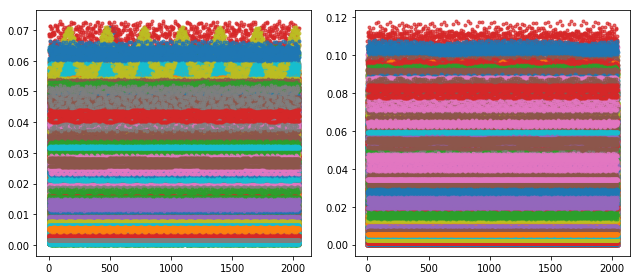

In [37]:
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
for i in range(npt):
    plt.plot(Inv0[i,:,0],marker='.',ls='',alpha=0.7)
plt.subplot(1,2,2)
for i in range(npt):
    plt.plot(Inv0[i,:,1],marker='.',ls='',alpha=0.7)
plt.tight_layout()

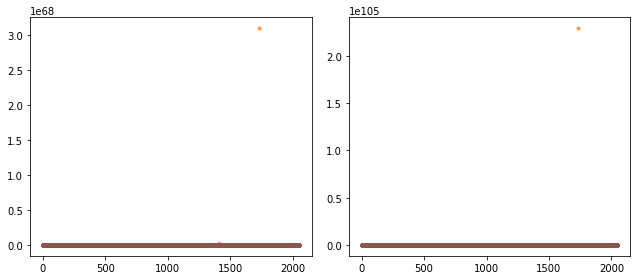

In [38]:
fig=plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
for i in range(npt):
    plt.plot(Inv1[i,:,0],marker='.',ls='',alpha=0.7)
plt.subplot(1,2,2)
for i in range(npt):
    plt.plot(Inv1[i,:,1],marker='.',ls='',alpha=0.7)
plt.tight_layout()

### relative inv

In [39]:
for i in range(npt):
    Inv0[i,:,0] = Inv0[i,:,0]/Inv0[i,0,0].mean()-1.0
    Inv0[i,:,1] = Inv0[i,:,1]/Inv0[i,0,1].mean()-1.0
    Inv1[i,:,0] = Inv1[i,:,0]/Inv1[i,0,0].mean()-1.0
    Inv1[i,:,1] = Inv1[i,:,1]/Inv1[i,0,1].mean()-1.0

In [40]:
print('--max invarinats--')
print(np.max(Inv0[:,:,0]),np.max(Inv0[:,:,1]))
print(np.max(Inv1[:,:,0]),np.max(Inv1[:,:,1]))

--max invarinats--
2.7182046597997824 12.196751044935713
nan nan


In [41]:
amp0 = np.zeros([npt,2])
amp1 = np.zeros([npt,2])
for i in range(npt):
    amp0[i,0] = np.std(Inv0[i,:,0])
    amp0[i,1] = np.std(Inv0[i,:,1])
    amp1[i,0] = np.std(Inv1[i,:,0])
    amp1[i,1] = np.std(Inv1[i,:,1])
print('--mean of amplitudes--')
print(amp0[:,0].mean(),amp0[:,1].mean())
print(amp1[:,0].mean(),amp1[:,1].mean())

--mean of amplitudes--
0.047755023104786326 0.062309711550171704
nan nan


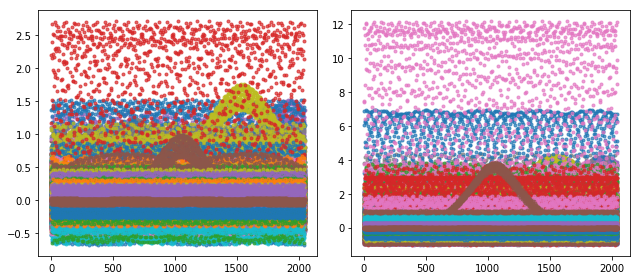

In [42]:
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
for i in range(npt):
    plt.plot(Inv0[i,:,0],marker='.',ls='',alpha=0.7)
plt.subplot(1,2,2)
for i in range(npt):
    plt.plot(Inv0[i,:,1],marker='.',ls='',alpha=0.7)
plt.tight_layout()

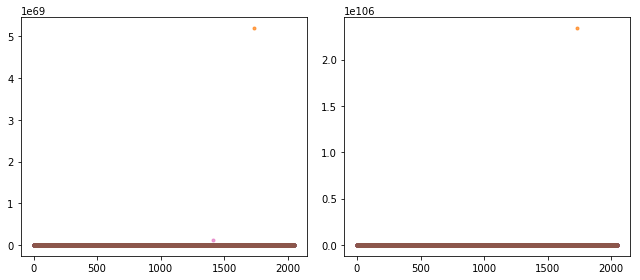

In [43]:
fig=plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
for i in range(npt):
    plt.plot(Inv1[i,:,0],marker='.',ls='',alpha=0.7)
plt.subplot(1,2,2)
for i in range(npt):
    plt.plot(Inv1[i,:,1],marker='.',ls='',alpha=0.7)
plt.tight_layout()